# 이미지 노이즈 제거를 위한 딥러닝 접근: 노이즈 제거 오토인코더(Denoising Autoencoder)

## 1. 이미지 노이즈 개요


### 1.1 이미지 노이즈와 그 영향

- 이미지 노이즈는 이미지 획득 과정에서 발생하는 무작위적인 변형으로, 이미지의 품질을 저하시킵니다.
- 노이즈는 컴퓨터 비전 및 이미지 처리 작업에서 성능 저하의 주요 원인 중 하나입니다.

<img src='https://blog.kakaocdn.net/dn/kJHb5/btqJt0wgWhH/cDOE6wwG17a9HrJriFYTU0/img.png'>

### 1.2 노이즈 제거 방법 개요
이미지 노이즈 제거는 중요한 전처리 단계로, 다음과 같은 방법들이 있습니다.

1. 단순 필터링 방법: 평균 필터, 미디안 필터 등

2. 딥러닝 기반 방법: 노이즈 제거 오토인코더 등

## 2. 데이터 준비

### 2.1 데이터셋 선택: CIFAR-10

- CIFAR-10은 32x32 크기의 컬러 이미지로 구성된 데이터셋으로, 10개의 클래스를 포함합니다.
- 비교적 작은 이미지 크기로 빠른 실험이 가능합니다.


### 2.2 데이터 로드 및 전처리

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 재현성을 위한 시드 설정
torch.manual_seed(42)

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),
])

# CIFAR-10 데이터셋 로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# 데이터로더 생성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                          shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


- torchvision.datasets.CIFAR10: CIFAR-10 데이터셋을 다운로드하고 로드합니다.
- transforms.ToTensor(): 이미지를 PyTorch 텐서로 변환합니다.

### 2.3 임의의 노이즈 추가

In [ ]:
def add_noise(inputs, noise_factor=0.5):
    noise = noise_factor * torch.randn_like(inputs)
    noisy_inputs = inputs + noise
    noisy_inputs = torch.clip(noisy_inputs, 0., 1.)
    return noisy_inputs

- noise_factor를 조절하여 노이즈의 강도를 조절할 수 있습니다.
- torch.clip을 사용하여 픽셀 값을 [0, 1] 범위로 제한합니다.

### 2.4 노이즈가 추가된 이미지 확인

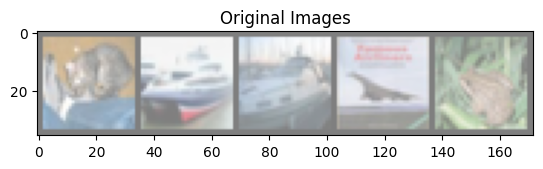

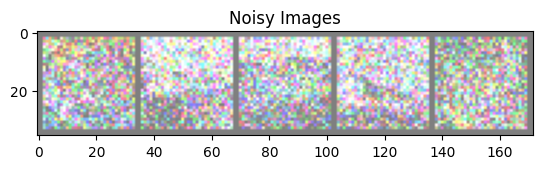

In [ ]:
# 일부 이미지 시각화
dataiter = iter(test_loader)
images, labels = next(dataiter)
noisy_images = add_noise(images)

# 시각화를 위한 함수
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# 원본 이미지
imshow(torchvision.utils.make_grid(images[:5]), title='Original Images')

# 노이즈가 추가된 이미지
imshow(torchvision.utils.make_grid(noisy_images[:5]), title='Noisy Images')

## 3. 노이즈 제거 방법 비교


### 3.1 단순 필터링 방법

#### 3.1.1 평균 필터


In [ ]:
import cv2

def mean_filter(img):
    img_np = img.numpy().transpose(1, 2, 0)
    filtered_img = cv2.blur(img_np, (3, 3))
    return torch.from_numpy(filtered_img.transpose(2, 0, 1))

OpenCV를 사용하여 필터링을 적용할 함수 생성 위는 평균 필터, 아래는 미디안 필터

#### 3.1.2 미디안 필터

In [ ]:
def median_filter(img):
    img_np = img.numpy().transpose(1, 2, 0)
    filtered_img = cv2.medianBlur((img_np * 255).astype(np.uint8), 3)
    return torch.from_numpy(filtered_img.transpose(2, 0, 1) / 255.0)

### 3.2 딥러닝 기반 방법: 노이즈 제거 오토인코더

- 위와 같이 단순 필터링을 통해 진행하는 방식과 비교하기 위해서 입력과 출력이 모두 노이즈가 추가된 이미지를 깨끗한 이미지를 복원하도록 모델을 학습해보도록 하겠습니다. (물론, 성능이 드라마틱하지는 않을 겁니다..ㅎ)

## 4. 모델 구현

### 4.1 모델 정의

In [ ]:
import torch.nn as nn

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # 인코더
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # [B, 128, 8, 8]
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # [B, 256, 4, 4]
            nn.ReLU(True),
        )

        # 디코더
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # [B, 128, 8, 8]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # [B, 64, 16, 16]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),  # [B, 3, 32, 32]
            nn.Sigmoid(),  # 출력 값을 [0,1]로 제한
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

- 인코더는 입력 이미지를 점점 작은 특징 맵으로 압축합니다.
    - 해당 과정에서 nn.Conv2d (2D 컨볼루션) 레이어를 활용해서, 이미지의 특징을 추출합니다.
- 디코더는 압축된 특징 맵을 다시 원본 크기로 복원합니다.
    - 해당 과정에서 nn.ConvTranspose2d (2D 역컨볼루션 레이어)로, 이미지의 크기를 복원합니다.

### 4.2 인코더 및 디코더 모델 요약

In [ ]:
from torchsummary import summary

model = DenoisingAutoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Encoder Summary:")
summary(model.encoder, (3, 32, 32))

print("\nDecoder Summary:")
summary(model.decoder, (256, 4, 4))

Encoder Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
              ReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]          73,856
              ReLU-4            [-1, 128, 8, 8]               0
            Conv2d-5            [-1, 256, 4, 4]         295,168
              ReLU-6            [-1, 256, 4, 4]               0
Total params: 370,816
Trainable params: 370,816
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 1.41
Estimated Total Size (MB): 1.86
----------------------------------------------------------------

Decoder Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   Con

### 4.3 모델 학습

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        noisy_inputs = add_noise(inputs)

        # 순전파
        outputs = model(noisy_inputs)
        loss = criterion(outputs, inputs)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}')

Epoch [1/10], Loss: 0.019683
Epoch [2/10], Loss: 0.012392
Epoch [3/10], Loss: 0.011432
Epoch [4/10], Loss: 0.010952
Epoch [5/10], Loss: 0.010694
Epoch [6/10], Loss: 0.010509
Epoch [7/10], Loss: 0.010365
Epoch [8/10], Loss: 0.010267
Epoch [9/10], Loss: 0.010152
Epoch [10/10], Loss: 0.010073


### 5. 결과 비교 및 해석

#### 5.1 필터링 방법의 결과

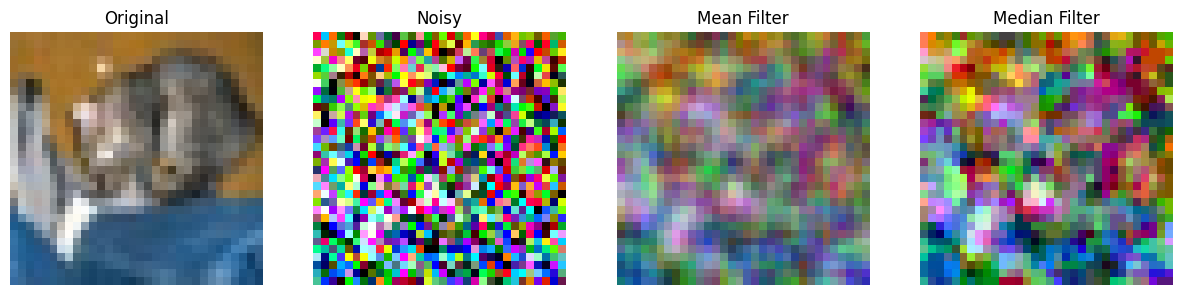

In [ ]:
# 원본 이미지, 노이즈 이미지, 평균 필터 결과, 미디안 필터 결과 시각화
sample_image = noisy_images[0]

mean_filtered_image = mean_filter(sample_image.cpu())
median_filtered_image = median_filter(sample_image.cpu())

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(sample_image.cpu().numpy().transpose(1, 2, 0))
axes[1].set_title('Noisy')
axes[1].axis('off')

axes[2].imshow(mean_filtered_image.numpy().transpose(1, 2, 0))
axes[2].set_title('Mean Filter')
axes[2].axis('off')

axes[3].imshow(median_filtered_image.numpy().transpose(1, 2, 0))
axes[3].set_title('Median Filter')
axes[3].axis('off')

plt.show()

- 단순 필터링 방법은 노이즈를 일부 제거하지만 이미지의 세부 정보가 손실될 수 있습니다.

#### 5.2 오토인코더의 결과

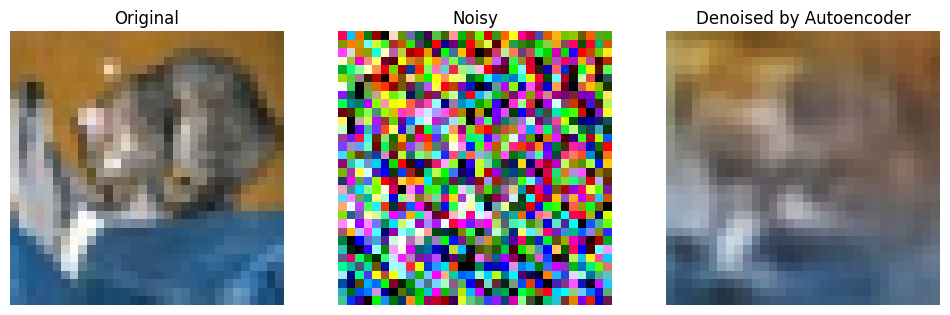

In [ ]:
# 오토인코더를 통한 노이즈 제거 결과 시각화
model.eval()
with torch.no_grad():
    outputs = model(noisy_images.to(device))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(noisy_images[0].cpu().numpy().transpose(1, 2, 0))
axes[1].set_title('Noisy')
axes[1].axis('off')

axes[2].imshow(outputs[0].cpu().numpy().transpose(1, 2, 0))
axes[2].set_title('Denoised by Autoencoder')
axes[2].axis('off')

plt.show()

#### 5.3 성능 비교

1. 단순 필터링 방법
    - 장점: 구현이 간단하고 빠름.
    - 단점: 이미지의 디테일이 흐려지거나 손실될 수 있음.
2. 노이즈 제거 오토인코더:

    - 장점: 노이즈를 효과적으로 제거하면서 이미지의 세부 정보를 유지.
    - 단점: 모델 학습에 시간이 소요됨.

## 6. 결론

1. 이미지 노이즈 제거는 컴퓨터 비전에서 중요한 전처리 단계입니다.
2. 단순한 필터링 방법은 구현이 쉽지만 한계가 있습니다.
3. 딥러닝 기반의 노이즈 제거 오토인코더는 복잡한 노이즈 패턴을 효과적으로 처리할 수 있습니다.
4. 오토인코더를 사용한 노이즈 제거는 이미지의 품질을 향상시키고, 후속 작업의 성능을 높일 수 있습니다.